In [2]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

In [3]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [4]:
# Parameters
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

days_history = 4
features = 4
learningrate = 0.05
epochs = 100
percent_training = 0.8
mid_layer_size = 32

weight_dev = 1 # standard deviation of weights
#stock_type = "STL"
stock_type = "MHG"


In [5]:
# Get dataset

def get_dataset(name):
    df = pd.read_csv(name, sep=';', index_col=0, encoding="Latin1")
    df = df[::-1]
    df.columns = ['Siste', 'Kjoper', 'Selger', 'Hoy', 'Lav', 'Totalt_omsatt_NOK', 'Totalt_antall_aksjer_omsatt', 'Antall_off_handler', 'Antall_handler_totalt', 'VWAP']
    return df


def get_currency_data(name):
    df = pd.read_csv(name, sep=';', index_col=0, encoding="Latin1")
    return df


def append_currency_to_stock_price_df(df_stock, df_currency):
    df_stock["Dollarkurs"] = df_currency["1 USD"]


stock = get_dataset("data\\" + stock_type + "_data.csv")
nok = get_currency_data("data\\Valutakurser.csv")

append_currency_to_stock_price_df(stock, nok)


In [6]:
# Initialize labels

Up = np.roll(stock.Siste.diff(1),-1) > 0

n = len(Up)

train = np.zeros((n, 2))
train[:,0] = (Up == 0)
train[:,1] = (Up == 1)

cutoff = int(np.floor(n*percent_training))

Y_train = train[:cutoff,:]
Y_test = train[cutoff:,:]

Y_train = Y_train[days_history:]
print(Y_train.shape)
print(Y_test.shape)

(998, 2)
(251, 2)


C:\Users\halvojon\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


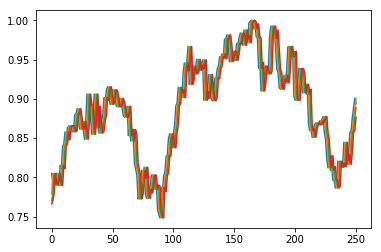

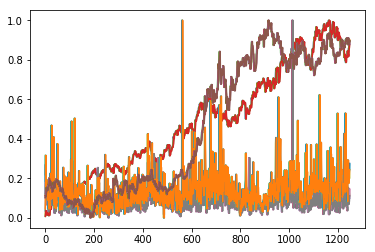

(1253, 16)
(998, 16)
(251, 16)


In [7]:
# Initialize training data
input_dimension = features*days_history

Siste_all = np.zeros((n, days_history))
Siste = stock.Siste.values

Omsatte_all = np.zeros((n, days_history))
Omsatte = stock.Totalt_antall_aksjer_omsatt.values

Antall_handler_all = np.zeros((n, days_history))
Antall_handler = stock.Antall_handler_totalt.values

Valutakurs_all = np.zeros((n, days_history))
Valutakurs = stock.Dollarkurs.values


def normalize(vector, ref):
    ref_min = min(ref)
    ref_max = max(ref)
    vector -= ref_min
    return vector / (ref_max-ref_min)
    

for i in range(days_history):
    Siste_all[:,i] = np.roll(Siste, i)
    Omsatte_all[:,i] = np.roll(Omsatte, i)
    Antall_handler_all[:,i] = np.roll(Antall_handler, i)
    Valutakurs_all[:,i] = np.roll(Valutakurs, i)
   
Siste_all = normalize(Siste_all, Siste)    
Omsatte_all = normalize(Omsatte_all, Omsatte)
Antall_handler_all = normalize(Antall_handler_all, Antall_handler)
Valutakurs_all = normalize(Valutakurs_all, Valutakurs)

plt.plot(Siste_all[cutoff:])
plt.show()


X_data = Siste_all

X_data = np.append(X_data,Omsatte_all, 1)
X_data = np.append(X_data,Antall_handler_all, 1)
X_data= np.append(X_data,Valutakurs_all, 1)


plt.plot(X_data[days_history:])
plt.show()
print(X_data.shape)

X_train = X_data[:cutoff,:]
X_test = X_data[cutoff:,:]
X_train = X_train[days_history:]
print(X_train.shape)
print(X_test.shape)

In [8]:
# Setup graph
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=weight_dev)
    return tf.Variable(weights)

# Layer's sizes
x_size = X_train.shape[1]  
h_size = mid_layer_size              
y_size = Y_train.shape[1] 

# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
h    = tf.nn.tanh(tf.matmul(X, w_1)) 
tf.summary.histogram('h', h)
yhat = tf.nn.softmax(tf.matmul(h, w_2))
tf.summary.histogram('yhat', yhat)
predict = tf.argmax(yhat, axis=1)
tf.summary.histogram('predict', predict)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
tf.summary.scalar('cross_entropy', cost)
updates = tf.train.GradientDescentOptimizer(learningrate).minimize(cost)


In [9]:
# Run graph
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
file_writer = tf.summary.FileWriter('C:\logg', sess.graph)
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(epochs):
    for i in range(len(X_train)):
        sess.run(updates, feed_dict={X: X_train[i: i + 1], y: Y_train[i: i + 1]})

    train_accuracy = np.mean(np.argmax(Y_train, axis=1) ==
                 sess.run(predict, feed_dict={X: X_train, y: Y_train}))
    test_accuracy  = np.mean(np.argmax(Y_test, axis=1) ==
                 sess.run(predict, feed_dict={X: X_test, y: Y_test}))
    train_negatives = np.average( sess.run(predict, feed_dict={X: X_train, y: Y_train}) == 0)
    train_positives = np.average( sess.run(predict, feed_dict={X: X_train, y: Y_train}) == 1)
    test_negatives = np.average( sess.run(predict, feed_dict={X: X_test, y: Y_test}) == 0)
    test_positives = np.average( sess.run(predict, feed_dict={X: X_test, y: Y_test}) == 1)
    print("Epoch = %d, tr_a = %.2f%%, te_a = %.2f%%. tr_pos: %.2f%%. tr_neg %.2f%%. te_pos: %.2f%%. te_neg %.2f%%."
          % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy, 100. * train_positives, 100. * train_negatives, 100.* test_positives, 100.*test_negatives))


Epoch = 1, tr_a = 51.60%, te_a = 50.20%. tr_pos: 100.00%. tr_neg 0.00%. te_pos: 98.41%. te_neg 1.59%.
Epoch = 2, tr_a = 51.70%, te_a = 51.39%. tr_pos: 99.90%. tr_neg 0.10%. te_pos: 97.21%. te_neg 2.79%.
Epoch = 3, tr_a = 51.80%, te_a = 52.59%. tr_pos: 98.80%. tr_neg 1.20%. te_pos: 92.83%. te_neg 7.17%.
Epoch = 4, tr_a = 51.90%, te_a = 52.59%. tr_pos: 96.49%. tr_neg 3.51%. te_pos: 89.64%. te_neg 10.36%.
Epoch = 5, tr_a = 52.20%, te_a = 53.39%. tr_pos: 94.19%. tr_neg 5.81%. te_pos: 84.86%. te_neg 15.14%.
Epoch = 6, tr_a = 52.51%, te_a = 53.78%. tr_pos: 91.68%. tr_neg 8.32%. te_pos: 82.07%. te_neg 17.93%.
Epoch = 7, tr_a = 52.51%, te_a = 53.39%. tr_pos: 91.28%. tr_neg 8.72%. te_pos: 76.10%. te_neg 23.90%.
Epoch = 8, tr_a = 52.51%, te_a = 52.19%. tr_pos: 91.88%. tr_neg 8.12%. te_pos: 73.31%. te_neg 26.69%.
Epoch = 9, tr_a = 52.61%, te_a = 51.39%. tr_pos: 91.78%. tr_neg 8.22%. te_pos: 70.92%. te_neg 29.08%.
Epoch = 10, tr_a = 52.61%, te_a = 52.99%. tr_pos: 91.58%. tr_neg 8.42%. te_pos: 69.3

Epoch = 81, tr_a = 52.61%, te_a = 53.78%. tr_pos: 89.18%. tr_neg 10.82%. te_pos: 41.43%. te_neg 58.57%.
Epoch = 82, tr_a = 52.61%, te_a = 53.78%. tr_pos: 89.18%. tr_neg 10.82%. te_pos: 41.43%. te_neg 58.57%.
Epoch = 83, tr_a = 52.51%, te_a = 53.78%. tr_pos: 89.08%. tr_neg 10.92%. te_pos: 41.43%. te_neg 58.57%.
Epoch = 84, tr_a = 52.51%, te_a = 53.78%. tr_pos: 89.08%. tr_neg 10.92%. te_pos: 41.43%. te_neg 58.57%.
Epoch = 85, tr_a = 52.51%, te_a = 54.18%. tr_pos: 89.08%. tr_neg 10.92%. te_pos: 41.04%. te_neg 58.96%.
Epoch = 86, tr_a = 52.51%, te_a = 54.58%. tr_pos: 89.08%. tr_neg 10.92%. te_pos: 40.64%. te_neg 59.36%.
Epoch = 87, tr_a = 52.51%, te_a = 54.58%. tr_pos: 89.08%. tr_neg 10.92%. te_pos: 40.64%. te_neg 59.36%.
Epoch = 88, tr_a = 52.61%, te_a = 54.58%. tr_pos: 89.18%. tr_neg 10.82%. te_pos: 40.64%. te_neg 59.36%.
Epoch = 89, tr_a = 52.61%, te_a = 54.58%. tr_pos: 89.18%. tr_neg 10.82%. te_pos: 40.64%. te_neg 59.36%.
Epoch = 90, tr_a = 52.61%, te_a = 54.58%. tr_pos: 89.18%. tr_neg

[[ 0.5391292   0.46087083]
 [ 0.43177861  0.56822139]
 [ 0.47970268  0.52029735]
 [ 0.36931047  0.6306895 ]
 [ 0.25954202  0.74045801]
 [ 0.10397648  0.89602351]
 [ 0.09349303  0.90650696]
 [ 0.1486772   0.85132283]
 [ 0.04395264  0.95604736]
 [ 0.1053919   0.89460814]
 [ 0.17220283  0.82779723]
 [ 0.50074029  0.49925971]
 [ 0.40243554  0.5975644 ]
 [ 0.32150486  0.67849523]
 [ 0.06424963  0.93575037]
 [ 0.03581677  0.96418321]
 [ 0.22211027  0.77788973]
 [ 0.25280789  0.74719214]
 [ 0.48023441  0.51976556]
 [ 0.82793927  0.17206068]
 [ 0.8368485   0.16315147]
 [ 0.91536021  0.08463978]
 [ 0.73499924  0.26500076]
 [ 0.82188356  0.1781164 ]
 [ 0.72458404  0.27541596]
 [ 0.71345055  0.28654948]
 [ 0.67897004  0.32102996]
 [ 0.50771016  0.49228975]
 [ 0.36055562  0.63944435]
 [ 0.75495929  0.24504073]
 [ 0.75490332  0.24509673]
 [ 0.86777204  0.13222794]
 [ 0.89087945  0.10912061]
 [ 0.26915869  0.73084128]
 [ 0.43502143  0.5649786 ]
 [ 0.30021992  0.69978005]
 [ 0.87974733  0.12025268]
 

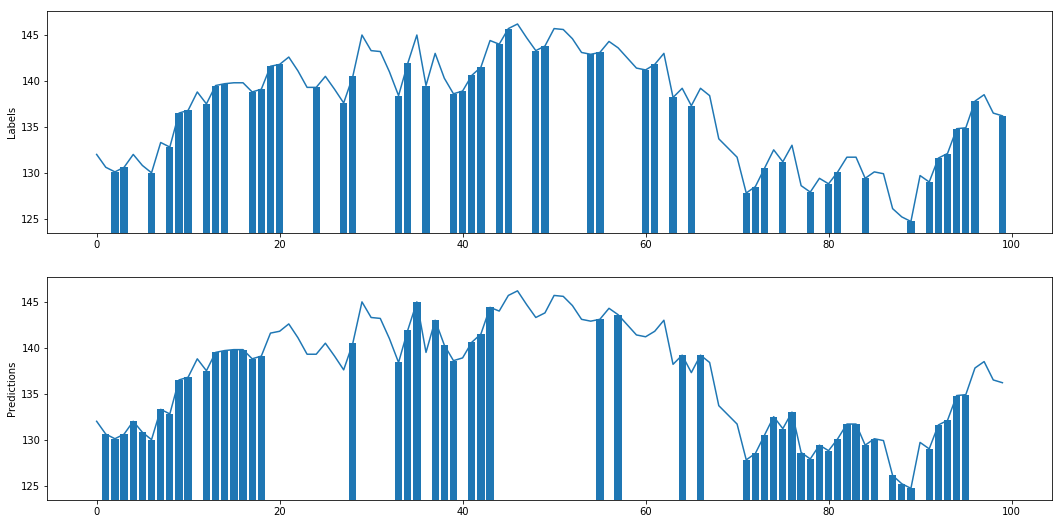

In [16]:
test_results = (np.argmax(Y_test, axis=1) == sess.run(predict, feed_dict={X: X_test, y: Y_test}))
print(sess.run(yhat, feed_dict={X: X_test, y: Y_test}))
predictions = sess.run(predict, feed_dict={X: X_test, y: Y_test})
labels = np.argmax(Y_test, axis=1)



#plt.subplot(2,1,1)
#plt.bar(ind,predictions[:50])
#plt.subplot(2,1,2)
#plt.bar(ind,labels[:50])
#plt.show()

start_index = 0
stop_index = 100
ind = range( stop_index - start_index)
print(predictions[start_index:stop_index])




test_data = Siste[cutoff + start_index:cutoff + stop_index]

val_max = max(test_data)
val_min = min(test_data)

plt.figure(figsize=(18,9))
plt.subplot(2,1,1)
plt.plot(test_data)
plt.bar(ind,labels[start_index:stop_index]*test_data)
plt.ylim([val_min*0.99,val_max*1.01])
plt.ylabel('Labels')
plt.subplot(2,1,2)
plt.plot(test_data)
plt.bar(ind,predictions[start_index:stop_index]*test_data)
plt.ylim([val_min*0.99,val_max*1.01])
plt.ylabel('Predictions')
plt.show()


#test_data = Valutakurs[cutoff + start_index:cutoff + stop_index]

#val_max = max(test_data)
#val_min = min(test_data)

#plt.figure(figsize=(18,9))
#plt.subplot(2,1,1)
#plt.plot(test_data)
#plt.bar(ind,labels[start_index:stop_index]*test_data)
#plt.ylim([val_min*0.99,val_max*1.01])
#plt.ylabel('Labels')
#plt.subplot(2,1,2)
#plt.plot(test_data)
#plt.bar(ind,predictions[start_index:stop_index]*test_data)
#plt.ylim([val_min*0.99,val_max*1.01])
#plt.ylabel('Predictions')
#plt.show()




In [ ]:
sess.close()